# Derby Air Pollution Project

## Workflow

1) Get data from URL

2) Clean data

3) Plot graph per hour

4) Plot graph per day etc, do resampling

In [1]:
### Imports ###

from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime

### Get data ###
URL_2020 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv'
URL_2019 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv'
URL_2018 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv'
URL_2017 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv' 


urlretrieve(URL_2020,'derby_2020.csv')
urlretrieve(URL_2019,'derby_2019.csv')
urlretrieve(URL_2018,'derby_2018.csv')
urlretrieve(URL_2017,'derby_2017.csv')

df_2020 = pd.read_csv('derby_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
df_2019 = pd.read_csv('derby_2019.csv',skiprows=4)
df_2018 = pd.read_csv('derby_2018.csv',skiprows=4)
df_2017 = pd.read_csv('derby_2017.csv',skiprows=4)
unit = 'ugm^3'

### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00

def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])

    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value

    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
    # making 'Date Time No Year' column
    variable['Date Time No Year'] = variable['Date Time'].dt.strftime('%d-%m %H:%M')
    
    # setting index to be the date time
    variable.index = variable['Date Time']
    
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]

df_all = pd.concat(frames)
df_all_index = df_all.copy()
df_all_index.index = df_all_index['Date Time']

# Exploratory data analysis

In [87]:
# function to let you decide date range to plot
def plot_date_range(dateinput,resample_string,plottype,aggregate):
    '''
    Parameters:
    dateinput = date string in format YYYY-MM-DD
    resample = string of 'H'/'D'/'W'/'M'
    plottype = string 'line' or 'bar'
    aggregate = string 'sum','average','median'
    '''
    resample_string = resample_string.upper() # just in case user were to input h instead of H
    
    # for title of chart
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # date to plot from 
    dateinput_datetime = datetime.strptime(dateinput,'%Y-%m-%d')
    
    # resampling based on input
    if resample_string == 'H':
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        if plottype == 'line':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        x.set_title('Hourly Emissions Since {}'.format(dateinput))
        x.set_ylim(0)
    else:    
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        if plottype == 'line':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            x.set_title('{} {} Emissions Since {}'.format(aggregate.title(),title_string,dateinput))
            x.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            x.set_title('{} {} Emissions Since {}'.format(aggregate.title(),title_string,dateinput))
            x.set_ylim(0)

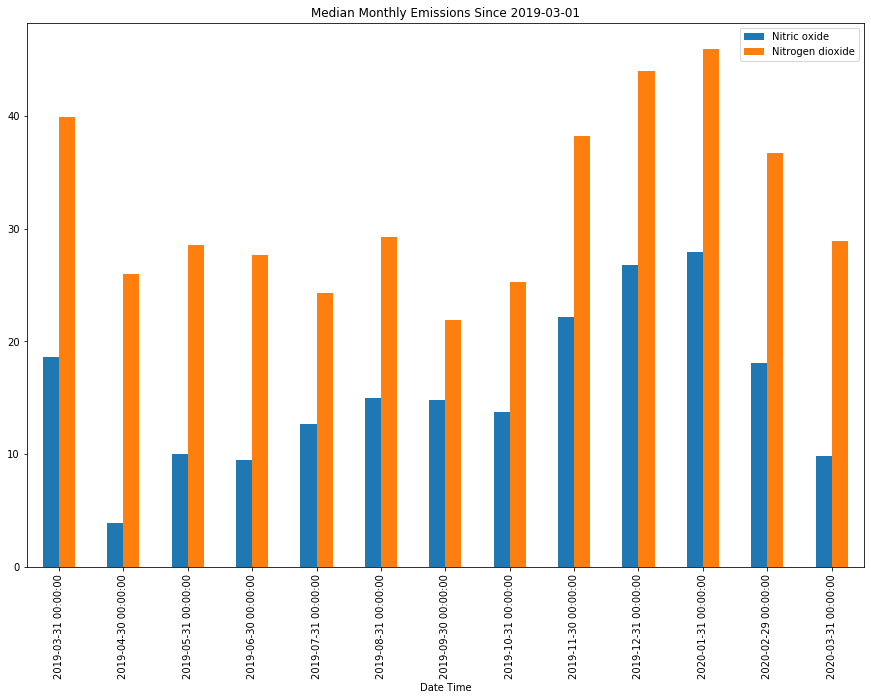

In [96]:
plot_date_range('2019-03-01','M','bar','median')

# Year comparison
- It'd be great to be able to plot each year's data on top of each othr
- Maybe best to do with subplots